# Kubeflow test flakiness report
This notebook reports kubeflow test flakiness. We leverqe [kettle](https://github.com/kubernetes/test-infra/tree/master/kettle) which uploads test metadata into bigquery upon publishing in GCS buckets via [Prow](https://github.com/kubernetes/test-infra/tree/master/prow). We also customize flakiness queries used in k8s infra-test [metrics](https://github.com/kubernetes/test-infra/tree/master/metrics) to compute daily flakiness metrics for kubeflow test jobs, junit tests and workflow resr.  

We aim to use this report to evaluate kubeflow flakiness and as clues to debug the flakiness in kubeflow test pipeline. At this stage, we conclude that kubeflow test metadata are not sufficient to provide clues for debugging flakiness. Also, we currently generate the rport for the kubeflow prs which trigger presubmit tests. Later we will expand it for all types of kubeflow tests.




# Flakines metrics for kubeflow test jobs
-  __job__: name of the test e.g., pr:kubeflow-presubmit (if a test is triggered by a pr, kettle adds "pr:" to the beginning of the job name.)
-  __start_date__: test start date
-  __runs__: total number of test runs during the day of the start date 
-  __flakes__: if different runs of a given commit report different result (some failed and some (one) passed), we say that flake happens for that commit. __flakes__ metric points to the number of flakes for all commits of the job during the day (start date) 
-  __passed__: total number of times that the job runs successfully.  
-  __failed__: total number of distinct commits which do not have not any successful run 
-  __flake_rate__: the ratio of number of flakes over the number of distinct commits
-  __commit_consistency__: one minus __flake_rate__
-  __build_consistency__: the ratio of useful runs over the total runs. If a job flakes then the last successful run is a useful run, otherwise all runs are useful. 
-  __flaky_runs__: __runs__ - __passed__ - __failed__





__Caveat__: flakiness metrics are correct for commits for which  a conclusion is made i.e., either it is passed or failed and is reflected in the logs. If a commit failed and future runs reveal that the failure was a flake, it won't be reflected in the current flakiness metrics. Therefore, we should look at flakiness report for a relatively long time (e.g., a week).    

In [74]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


# Compute daily flakiness of kubeflow presubmit tests

In [76]:
%%bigquery daily_flakiness
select 
    job,
    start_date,
    round(sum(if(flaked=1,passed,runs))/sum(runs),3) build_consistency,
    round(1-sum(flaked)/count(distinct commit),3) commit_consistency,
    round (sum(flaked)/count(distinct commit),3) flake_rate,
    sum(flaked) flakes,
    sum(runs) runs,
    sum(passed) passed,
    sum(flaky_runs) flaky_runs,
    sum(failed) failed
    
  from ( /* Determine whether a (job, pr-num, commit) flaked */
    select
      job,
      start_date,
      num,
      commit,
      if(passed = runs or passed = 0, 0, 1) flaked,
      if(passed = runs or passed = 0, 0, runs-passed) flaky_runs, 
      if(passed = 0, runs, 0) failed, 
      passed,
      CAST(runs as INT64) runs
    from (
      select /* Count the runs and passes for each (job, pr-num, commit) */
        max(start_date) start_date,
        num,
        commit,
        sum(if(result='SUCCESS',1,0)) passed,
        count(result) runs,
        job
      from (
        SELECT /* all runs of any job for the past week, noting the commit and whether it passed */
          job,
          regexp_extract(path, r'/(\d+)\/') as num, /* pr number */
          regexp_extract(m.value, r'[^,]+,\d+:([a-f0-9]+)"') commit, /* extract the first commit id from the repo flag */
          EXTRACT(DATE FROM started) start_date,    
          result
        FROM `k8s-gubernator.build.all` , UNNEST(metadata) as m
        where
          started > TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 672 HOUR)
          and (m.key = "repos") and STRPOS(job,'kubeflow') > 0 and STRPOS(job,'pr:') > 0
      )
      group by job, num, commit
    )
  )
  group by job, start_date
  order by
    flakes desc,
    build_consistency,
    commit_consistency,
    job

,job,start_date,build_consistency,commit_consistency,flake_rate,flakes,runs,passed,flaky_runs,failed
0,pr:kubeflow-presubmit,2019-04-19,0.614,0.591,0.409,9,44,17,17,10
1,pr:kubeflow-presubmit,2019-04-23,0.706,0.667,0.333,6,34,17,10,7
2,pr:kubeflow-presubmit,2019-04-03,0.857,0.750,0.250,3,21,18,3,0
3,pr:kubeflow-presubmit,2019-04-05,0.900,0.850,0.150,3,30,22,3,5
4,pr:kubeflow-tf-operator-presubmit,2019-04-23,0.500,0.333,0.667,2,10,3,5,2
5,pr:kubeflow-katib-presubmit,2019-04-26,0.667,0.500,0.500,2,6,4,2,0
6,pr:kubeflow-presubmit,2019-04-06,0.667,0.667,0.333,2,9,5,3,1
7,pr:kubeflow-presubmit,2019-04-10,0.842,0.846,0.154,2,19,4,3,12
8,pr:kubeflow-presubmit,2019-04-26,0.950,0.935,0.065,2,40,19,2,19
9,pr:kubeflow-katib-presubmit,2019-04-02,0.500,0.000,1.000,1,2,1,1,0


# Daily flake rate  of all presubmit tests over time

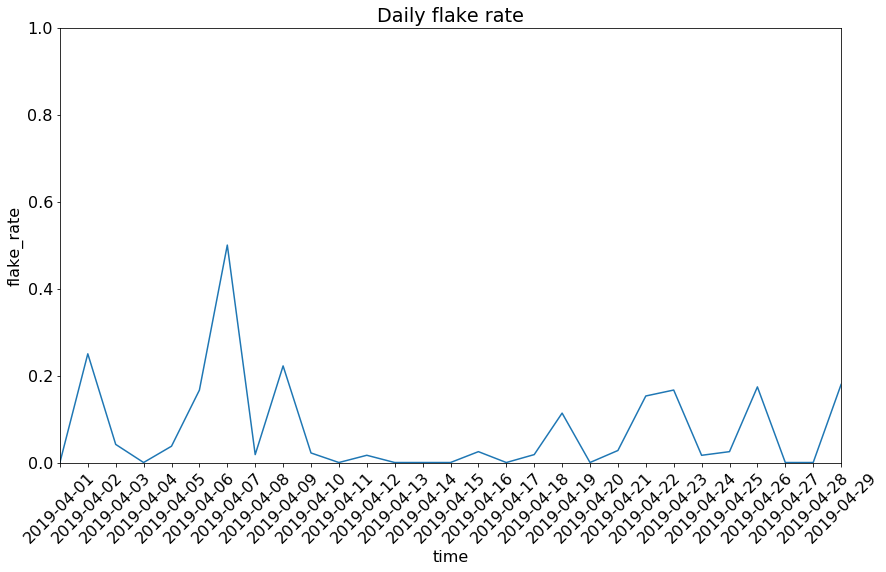

In [78]:
import pandas as pd
overal_flakes = pd.DataFrame(daily_flakiness).groupby("start_date",as_index=False).agg(
{ 'flake_rate':'mean',
  'flakes' :'sum',
   'runs' : 'sum'
})
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
matplotlib.rc('font', size=16)
ax=overal_flakes.flake_rate.plot(xticks=overal_flakes.index,figsize=(14,8), rot=45)
plt.title('Daily flake rate')
plt.xlabel('time')
plt.ylabel('flake_rate')
ax.set_xticklabels(overal_flakes['start_date'])
plt.ylim([0,1])

 

plt.show()


# Daily build and commit consistency of all presubmit tests
As illustreated by the plot, build_consistency and commit_consistency are expectedly corrolated. 
Note that build_consistency is computed with respect to the total number of runs whereas commit_consistency is computed with respect to distinct number of commits. This means that if number of flaky runs increases (i.e., runing retest) then build_consistency becomes lower than commit_consistency. 

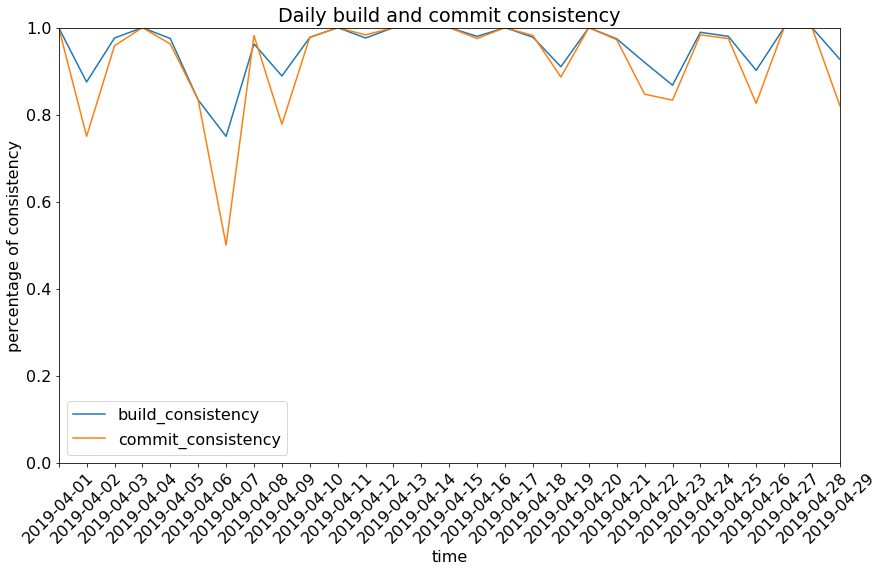

In [79]:
import pandas as pd
overal_consistency = pd.DataFrame(daily_flakiness).groupby("start_date",as_index=False).agg(
{ 'build_consistency':'mean',
  'commit_consistency' :'mean'
})
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
matplotlib.rc('font', size=16)
ax1=overal_consistency.build_consistency.plot(xticks=overal_consistency.index,figsize=(14,8), rot=45)
ax2=overal_consistency.commit_consistency.plot(xticks=overal_consistency.index,figsize=(14,8), rot=45)

plt.title('Daily build and commit consistency')
plt.xlabel('time')
plt.ylabel('percentage of consistency')
ax1.set_xticklabels(overal_consistency['start_date'])
plt.legend()
plt.ylim([0,1])

plt.show()

# Flakiness per job

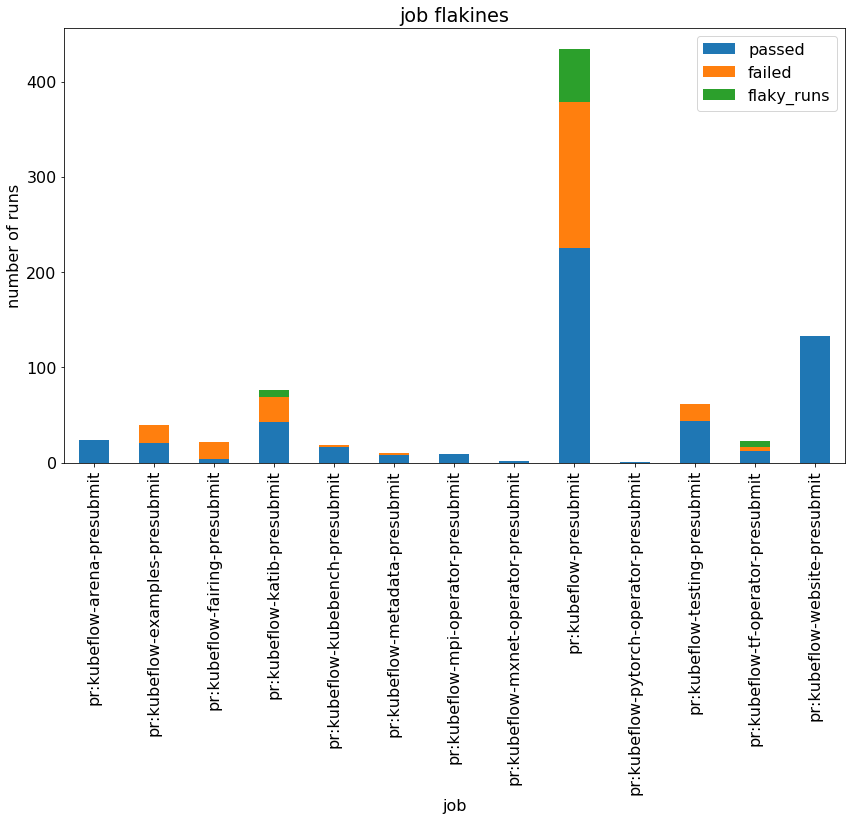

In [80]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

job_flakiness=pd.DataFrame(daily_flakiness).groupby("job",as_index=False).agg(
{ 'passed':'sum',
  'failed' :'sum',
   'flaky_runs' : 'sum'
})
matplotlib.rc('font', size=16)
ax=job_flakiness[['passed','failed','flaky_runs']].plot(kind='bar', stacked=True, xticks=job_flakiness.index, figsize=(14,8), rot=90)
ax.set_xticklabels(job_flakiness['job'])
plt.title('job flakines')
plt.xlabel('job')
plt.ylabel('number of runs')
plt.show()

# Overal failure rate per test type

Below we computer failure rate per junit tests as well as workflow tests.
Kettle stores Junit mtadata in the column "test".
Workflow tests results are stored in the column "metadata" whcih is a map. if key ends with "-phase", the key contains workflow test name and the value indicates whether it is succeeded or failed. 

* Caveat: For kubeflow-presubmit jobs, the test columns sometimes have the information of workflow tests which looks like a bug. For the folllowing results, such data are filtered out.  


# Overal failure rate per Junit tests

In [200]:
%%bigquery teststats
CREATE TEMP FUNCTION removeFirstChar(x STRING)
RETURNS STRING
LANGUAGE js AS """
  if (x.charAt(0) == '-') {
    x=x.substr(1);
  }
  return x;
""";
SELECT testname,runs,failures,filurepercentage
FROM(
SELECT
  removeFirstChar(t.name) testname,
  SUM(CASE WHEN t.failed=TRUE THEN 1 ELSE 0 END) failures,
  COUNT(*) runs,
  ROUND(SUM(CASE WHEN t.failed=TRUE THEN 1 ELSE 0 END)/COUNT(*)*100, 2) filurepercentage
FROM
 `k8s-gubernator.build.all`, UNNEST(test) as t
WHERE
   job LIKE '%kubeflow-presubmit%'
GROUP BY
  testname
) WHERE testname not LIKE '%kubeflow-presubmit%'
order by filurepercentage DESC
    

,testname,runs,failures,filurepercentage
0,deploy-kubeflow-deploy_model-inceptionGpu,1,1,100.00
1,deploy-kubeflow-deploy_model-inceptionCpu,1,1,100.00
2,deploy-kubeflow-deploy_model-gpu,1,1,100.00
3,github.com/kubeflow/kubeflow/bootstrap/v2/pkg/...,1,1,100.00
4,deploy-kubeflow-deploy_sparkjob-spark-job,11,8,72.73
5,deploy-kubeflow-deploy_pytorchjob-inception-cpu,3,2,66.67
6,test_katib,7,4,57.14
7,deploy-kubeflow-deploy_pytorchjob-inception-gpu,2,1,50.00
8,test-jsonnet-format,4,1,25.00
9,deploy_model-mnist-gpu,17,4,23.53


# Overal failure rate per workflow phase tests

In [201]:
%%bigquery teststats
CREATE TEMP FUNCTION getWorkflowTestName(x STRING)
RETURNS STRING
LANGUAGE js AS """
  var r=/\\d/;
  var y=x.replace("-e2e","-endtoend");
  var fd=r.exec(y);
  y=y.substring(0, y.indexOf(fd) - 1);
  y=y.replace("-endtoend","-e2e");
  return y;
""";
Select 
    testname,
    SUM(CASE WHEN mvalue ="Succeeded" THEN 0 ELSE 1 END) failures,
    COUNT(*) runs,
    ROUND(SUM(CASE WHEN mvalue ="Succeeded" THEN 0 ELSE 1 END)/COUNT(*)*100, 2) filurepercentage
From(
    Select getWorkflowTestName(mkey) testname,mvalue
    FROM(
        SELECT m.key mkey, m.value mvalue
        FROM
         `k8s-gubernator.build.all`,UNNEST(metadata) as m
        WHERE
           job LIKE '%kubeflow-presubmit%' and ENDS_WITH(m.key, "-phase")
    )
)
GROUP BY testname
ORDER BY filurepercentage DESC

,testname,failures,runs,filurepercentage
0,kubeflow-presubmit-jupyter-web-app-release,2,2,100.00
1,kubeflow-presubmit-deployapp,33,38,86.84
2,kubeflow-presubmit-kfctl-go,218,401,54.36
3,kubeflow-presubmit-kfctl-go-basic-auth,108,232,46.55
4,kubeflow-presubmit-kfctl-go-iap-istio,41,91,45.05
5,kubeflow-presubmit-kfctl-beta,124,329,37.69
6,kubeflow-presubmit-kubeflow-gke-deploy,131,370,35.41
7,kubeflow-presubmit-tf-notebook-release,162,458,35.37
8,kubeflow-presubmit-kfctl,1096,3129,35.03
9,kubeflow-presubmit-kfctl-go-iap,128,381,33.60


# Flakiness per junit tests

following are list of daily flakiness metrics used for jubit tests
- testname: junit test name
- flakes: number of commits whcih has flakes
- runs: total number of runs
- failed: total number of times that test failed
- passed: total number of times that the test passed
- flake_failures: number of flake failures, i.e, test passed in the same commit
- actual_failures: number of actual failures (test nerver passed in the same commit)
- flake_rate: the ratio of flake_failures over runs
- failure_rate: the ratio of sum of flake_failures and actual_failures over runs    
    

# Flakiness per JUnit test
Here we first compute junit results along with kubeflow test job result per commit and filter out commits whcih has flakes. A commit is said to flake if some of runs pass and some fail. Here are the columns:

- testname: junit test name
- job: kubeflow jib name
- num, pr number
- path, jerkins path which has all test artifacts
- commit, commit id (used for debugging)
- runs: total runs of the job
- job_passed, total number of times kubeflow job is passed
- job_failed, total number of times kubeflow job is failed
- test_passed, total number of times  junit test is passed
- test_failed,  total number of times  junit test is failed 
- test_elapsed_time: array of junit test duration times for all runs






In [91]:
%%bigquery testkfisready
CREATE TEMP FUNCTION removeFirstChar(x STRING)
RETURNS STRING
LANGUAGE js AS """
  if (x.charAt(0) == '-') {
    x=x.substr(1);
  }
  return x;
""";
SELECT
testname,
job,
runs,
test_failed,
test_passed,
job_passed,
job_failed,
num,
path,
commit,
test_elapsed_time
FROM(
SELECT
            testname,
            count(*) runs,
            sum(job_passed) job_passed,
            count(*) - sum(job_passed) job_failed,
            max(start_date) start_date,
            sum(test_failed) test_failed,
            sum(test_passed) test_passed,
            num,
            array_agg(path) path,
            commit,
            job,
            array_agg(test_elapsed_time) test_elapsed_time
        FROM(
                SELECT  /* collect stats per (commit, testname)*/ 
                   t.name testname,
                    CASE WHEN t.failed=TRUE THEN 1 ELSE 0 END test_failed,
                    CASE WHEN t.failed=TRUE THEN 0 ELSE 1 END test_passed,
                    job_passed,
                    t.time test_elapsed_time,
                    num,
                    path path,
                    job,
                    start_date start_date, 
                    regexp_extract(commit, r'[^,]+,\d+:([a-f0-9]+)"') commit /* extract the first commit id from the repo flag */  
                FROM( /* collect kubeflow commit rows */    
                        SELECT
                            path,
                            m.value commit,
                            test,
                            job,
                            EXTRACT(DATE FROM started) start_date,
                            regexp_extract(path, r'/(\d+)\/') as num, /* pr number */
                            CASE WHEN result='SUCCESS' THEN 1 ELSE 0 END job_passed
                        FROM
                            `k8s-gubernator.build.all`, UNNEST(metadata) as m
                        WHERE
                             job LIKE '%kubeflow-presubmit%'
                             and started > TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 700 HOUR)
                             and (m.key = "repos") and STRPOS(job,'kubeflow') > 0 and STRPOS(job,'pr:') > 0
                ), UNNEST(test) as t
                where t.name  not LIKE '%kubeflow-presubmit%' 
        )               
         GROUP BY testname,commit,num,job
) where job_passed>0 and job_failed>0 and test_failed>0



,testname,job,runs,test_failed,test_passed,job_passed,job_failed,num,path,commit,test_elapsed_time
0,test_jupyter,pr:kubeflow-presubmit,3,1,2,2,1,3054,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3054/kubeflow-presubmit/1119350159717699584, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3054/kubeflow-presubmit/1119373185905594368, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3054/kubeflow-presubmit/1119365009265135616]",9c30c55af3953949786b105dc528037187e5f33a,"[499.999101877, 144.438695431, 137.151001215]"
1,smoke-tfjob-gke,pr:kubeflow-presubmit,4,1,3,2,2,3076,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3076/kubeflow-presubmit/1120474461988982790, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3076/kubeflow-presubmit/1120450807234301952, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3076/kubeflow-presubmit/1120487425504710656, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3076/kubeflow-presubmit/1120526684731215872]",6eb179fd242e89273251ba48d59c7543e6853194,"[155.927994013, 236.323633909, 342.449174881, 262.728005171]"
2,test_kf_is_ready,pr:kubeflow-presubmit,2,1,1,1,1,3084,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3084/kubeflow-presubmit/1120775430350049280, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3084/kubeflow-presubmit/1120757562539511808]",043c94a4436dbd2b8111d5e171b3bf144b6d8532,"[13.9820113182, 145.926799297]"
3,smoke-tfjob-gke,pr:kubeflow-presubmit,4,1,3,2,2,3033,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3033/kubeflow-presubmit/1119352046579879941, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3033/kubeflow-presubmit/1119330151297978369, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3033/kubeflow-presubmit/1119360729003069440, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3033/kubeflow-presubmit/1119304989001388032]",ea5aefd3ece74b9db6888b74a364a2c1cf19fd8e,"[275.168391943, 244.398232937, 230.675370932, 289.99135685]"
4,test_kf_is_ready,pr:kubeflow-presubmit,6,1,5,2,4,3050,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3050/kubeflow-presubmit/1119020108560207872, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3050/kubeflow-presubmit/1119020108560207872, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3050/kubeflow-presubmit/1118981355057713152, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3050/kubeflow-presubmit/1118981355057713152, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3050/kubeflow-presubmit/1119111461247913989, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3050/kubeflow-presubmit/1119111461247913989]",6fdb981200859a9a57e3cf91e8eb2ec14fae4cda,"[4.24729561806, 14.1647980213, 4.01061105728, 125.965969324, 4.02977609634, 54.4593570232]"
5,test_jupyter,pr:kubeflow-presubmit,3,1,2,1,2,3028,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3028/kubeflow-presubmit/1119330151297978368, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3028/kubeflow-presubmit/1119305117774909440, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3028/kubeflow-presubmit/1119295048870006784]",0468fa449ffd6d5198643f55a9e699ba6f2b4102,"[144.703732967, 170.251648426, 499.997436762]"
6,kfctl-deploy_argo-test-argo-deploy,pr:kubeflow-presubmit,3,1,2,2,1,2556,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/2556/kubeflow-presubmit/1116048391722242048, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/2556/kubeflow-presubmit/1113869527126380547, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/2556/kubeflow-presubmit/1113869275094847488]",ebfe07ab1eaf2163286961552528a063c9e1bf29,"[24.2773940563, 21.4013600349, 24.7913579941]"
7,smoke-tfjob-gke,pr:kubeflow-presubmit,3,1,2,1,2,3028,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3028/kubeflow-presubmit/1119330151297978368, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3028/kubeflow-presubmit/1119305117774909440, gs://kubernetes-jenkins/pr-logs/pull/kube

In [40]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(testkfisready)



,testname,runs,test_failures,test_passes,jobpassedResult,jobfailed,num,path,commit,job,ttime
0,smoke-tfjob-gke,2,1,1,1,1,3066,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3066/kubeflow-presubmit/1120074453217185792, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3066/kubeflow-presubmit/1120052808737886208]",e3097a17e9189d5a799e264260b5229e7b158342,pr:kubeflow-presubmit,"[328.292748928, 393.276281118]"
1,test_build_kfctl_go,6,1,5,3,3,3069,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3069/kubeflow-presubmit/1120195750576263168, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3069/kubeflow-presubmit/1120195750576263168, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3069/kubeflow-presubmit/1120195750576263168, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3069/kubeflow-presubmit/1120176121636196352, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3069/kubeflow-presubmit/1120176121636196352, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3069/kubeflow-presubmit/1120176121636196352]",b3c8779e61a9327755125769f6a9afef53141382,pr:kubeflow-presubmit,"[1757.93426561, 1080.85015035, 1826.23394561, 1285.40969586, 1018.37596416, 1248.09989595]"
2,smoke-tfjob-gke,4,1,3,2,2,3076,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3076/kubeflow-presubmit/1120474461988982790, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3076/kubeflow-presubmit/1120450807234301952, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3076/kubeflow-presubmit/1120487425504710656, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3076/kubeflow-presubmit/1120526684731215872]",6eb179fd242e89273251ba48d59c7543e6853194,pr:kubeflow-presubmit,"[155.927994013, 236.323633909, 342.449174881, 262.728005171]"
3,test_kf_is_ready,2,1,1,1,1,3084,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3084/kubeflow-presubmit/1120775430350049280, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3084/kubeflow-presubmit/1120757562539511808]",043c94a4436dbd2b8111d5e171b3bf144b6d8532,pr:kubeflow-presubmit,"[13.9820113182, 145.926799297]"


In [82]:
%%bigquery testkfisready
CREATE TEMP FUNCTION getWorkflowTestName(x STRING)
RETURNS STRING
LANGUAGE js AS """
  var r=/\\d/;
  var y=x.replace("-e2e","-endtoend");
  var fd=r.exec(y);
  y=y.substring(0, y.indexOf(fd) - 1);
  y=y.replace("-endtoend","-e2e");
  return y;
""";
SELECT 
    testname,
    runs,
    wf_passed,
    wf_failed,
    passed,
    failed,
    start_date,
    num,
    job,
    commit,
    path,
    IF(failed>0 and passed>0 and wf_failed>0, 1,0) wf_flake,
    if(failed>0 and passed> 0, 1,0) flake
FROM(
    SELECT 
        testname,
        count(*) runs,
        sum(wf_passed) wf_passed,
        sum(wf_failed) wf_failed,
        sum(passed) passed,
        sum(failed) failed,
        max(start_date) start_date,
        num,
        array_agg(path) path,
        job,
        commit
    FROM(
        SELECT 
            getWorkflowTestName(m.key) testname,
            IF(m.value="Succeeded", 1, 0) wf_passed,
            IF(m.value="Succeeded", 0, 1) wf_failed,
            regexp_extract(commit, r'[^,]+,\d+:([a-f0-9]+)"') commit,
            job,
            path,
            start_date,
            num,
            passed,
            failed
        FROM(
            SELECT
                                path,
                                test,
                                job,
                                metadata,
                                EXTRACT(DATE FROM started) start_date,
                                regexp_extract(path, r'/(\d+)\/') as num, /* pr number */
                                CASE WHEN result='SUCCESS' THEN 1 ELSE 0 END passed,
                                CASE WHEN result='SUCCESS' THEN 0 ELSE 1 END failed,
                                (SELECT m.value  From UNNEST(metadata) as m where m.key = "repos") as commit
                            FROM
                                `k8s-gubernator.build.all`
                            WHERE
                                 job LIKE '%kubeflow-presubmit%'
                                 and started > TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 168 HOUR)
                                 and STRPOS(job,'kubeflow') > 0 and STRPOS(job,'pr:') > 0
        ), UNNEST(metadata) as m
        where
            job LIKE '%kubeflow-presubmit%' and ENDS_WITH(m.key, "-phase")
    )
    group by testname,job,commit,num
)WHERE failed>0 and passed>0 and wf_failed>0
    

,testname,runs,wf_passed,wf_failed,passed,failed,start_date,num,job,commit,path,wf_flake,flake
0,kubeflow-presubmit-kfctl,2,1,1,1,1,2019-04-26,3107,pr:kubeflow-presubmit,d08d5dfbc33e14473fe23d1046bcab5f39b1661c,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3107/kubeflow-presubmit/1121394824797229056, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3107/kubeflow-presubmit/1121643928618012672]",1,1
1,kubeflow-presubmit-kfctl-go-basic-auth,2,1,1,1,1,2019-04-23,3078,pr:kubeflow-presubmit,f710b2ed53da93c0b4979f0892c0f3eaa56571b7,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3078/kubeflow-presubmit/1120464020181094400, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3078/kubeflow-presubmit/1120487297196756993]",1,1
2,kubeflow-presubmit-kfctl-go-iap-istio,4,2,2,2,2,2019-04-23,3076,pr:kubeflow-presubmit,6eb179fd242e89273251ba48d59c7543e6853194,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3076/kubeflow-presubmit/1120474461988982790, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3076/kubeflow-presubmit/1120450807234301952, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3076/kubeflow-presubmit/1120487425504710656, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3076/kubeflow-presubmit/1120526684731215872]",1,1
3,kubeflow-presubmit-kfctl-go-iap-istio,2,1,1,1,1,2019-04-24,3070,pr:kubeflow-presubmit,7d9ae60a0e9dfdf0a7a90ee42f68d1f9ebabbe7a,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3070/kubeflow-presubmit/1120872574964731904, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3070/kubeflow-presubmit/1120888931932442624]",1,1
4,kubeflow-presubmit-jupyterui-release,2,1,1,1,1,2019-04-26,3107,pr:kubeflow-presubmit,d08d5dfbc33e14473fe23d1046bcab5f39b1661c,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3107/kubeflow-presubmit/1121394824797229056, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3107/kubeflow-presubmit/1121643928618012672]",1,1
5,kubeflow-presubmit-tf-notebook-release,2,1,1,1,1,2019-04-26,3107,pr:kubeflow-presubmit,d08d5dfbc33e14473fe23d1046bcab5f39b1661c,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3107/kubeflow-presubmit/1121394824797229056, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3107/kubeflow-presubmit/1121643928618012672]",1,1
6,kubeflow-presubmit-tf-notebook-release,3,2,1,2,1,2019-04-26,3117,pr:kubeflow-presubmit,d4f03826496f95333f96287443c0e03592cf6d77,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3117/kubeflow-presubmit/1121658781114044416, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3117/kubeflow-presubmit/1121848907471523840, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3117/kubeflow-presubmit/1121897968744534017]",1,1
7,kubeflow-presubmit-kfctl-go-basic-auth,3,1,2,1,2,2019-04-29,3124,pr:kubeflow-presubmit,5274cdf78d029867688257716bcb46342e7ef7ee,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3124/kubeflow-presubmit/1121918100388712448, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3124/kubeflow-presubmit/1122855513919328262, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3124/kubeflow-presubmit/1122877286677221376]",1,1
8,kubeflow-presubmit-kfctl-beta,3,2,1,1,2,2019-04-29,3124,pr:kubeflow-presubmit,5274cdf78d029867688257716bcb46342e7ef7ee,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3124/kubeflow-presubmit/1121918100388712448, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3124/kubeflow-presubmit/1122855513919328262, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3124/kubeflow-presubmit/1122877286677221376]",1,1
9,kubeflow-presubmit-unittests,3,2,1,1,2,2019-04-29,3124,pr:kubeflow-presubmit,5274cdf78d029867688257716bcb46342e7ef7ee,"[gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3124/kubeflow-presubmit/1121918100388712448, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3124/kubeflow-presubmit/1122855513919328262, gs://kubernetes-jenkins/pr-logs/pull/kubeflow_kubeflow/3124/kubeflow-presubmi

In [71]:
%%bigquery testkfisready
CREATE TEMP FUNCTION getWorkflowTestName(x STRING)
RETURNS STRING
LANGUAGE js AS """
  var r=/\\d/;
  var y=x.replace("-e2e","-endtoend");
  var fd=r.exec(y);
  y=y.substring(0, y.indexOf(fd) - 1);
  y=y.replace("-endtoend","-e2e");
  return y;
""";
SELECT
testname,
sum(runs) runs,
sum(passed) passed,
sum(failed) failed,
sum(wf_passed) wf_passed,
sum(wf_failed) wf_failed,
sum(if(wf_failed>0 and flake>0,1,0)) wf_flakes,
sum(flake) flakes
FROM(
    SELECT 
        testname,
        runs,
        wf_passed,
        wf_failed,
        passed,
        failed,
        start_date,
        num,
        job,
        commit,
        path,
        if(failed>0 and passed> 0, 1,0) flake
    FROM(
        SELECT 
            testname,
            count(*) runs,
            sum(wf_passed) wf_passed,
            sum(wf_failed) wf_failed,
            sum(passed) passed,
            sum(failed) failed,
            max(start_date) start_date,
            num,
            array_agg(path) path,
            job,
            commit
        FROM(
            SELECT 
                getWorkflowTestName(m.key) testname,
                IF(m.value="Succeeded", 1, 0) wf_passed,
                IF(m.value="Succeeded", 0, 1) wf_failed,
                regexp_extract(commit, r'[^,]+,\d+:([a-f0-9]+)"') commit,
                job,
                path,
                start_date,
                num,
                passed,
                failed
            FROM(
                SELECT
                                    path,
                                    test,
                                    job,
                                    metadata,
                                    EXTRACT(DATE FROM started) start_date,
                                    regexp_extract(path, r'/(\d+)\/') as num, /* pr number */
                                    CASE WHEN result='SUCCESS' THEN 1 ELSE 0 END passed,
                                    CASE WHEN result='SUCCESS' THEN 0 ELSE 1 END failed,
                                    (SELECT m.value  From UNNEST(metadata) as m where m.key = "repos") as commit
                                FROM
                                    `k8s-gubernator.build.all`
                                WHERE
                                     job LIKE '%kubeflow-presubmit%'
                                     and started > TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 600 HOUR)
                                     and STRPOS(job,'kubeflow') > 0 and STRPOS(job,'pr:') > 0
                                     and regexp_extract(path, r'/(\d+)\/') is not null
            ), UNNEST(metadata) as m
            where
                job LIKE '%kubeflow-presubmit%' and ENDS_WITH(m.key, "-phase")
        )
        group by testname,job,commit,num
    )WHERE failed>0 and passed>0 and wf_failed>0
) group by testname
order by wf_flakes DESC

,testname,runs,passed,failed,wf_passed,wf_failed,wf_flakes,flakes
0,kubeflow-presubmit-kfctl-go-iap,65,29,36,35,30,22,22
1,kubeflow-presubmit-tf-notebook-release,34,14,20,21,13,11,11
2,kubeflow-presubmit-kfctl,30,13,17,20,10,10,10
3,kubeflow-presubmit-unittests,27,12,15,17,10,10,10
4,kubeflow-presubmit-kfctl-go-basic-auth,25,10,15,12,13,9,9
5,kubeflow-presubmit-kfctl-go-iap-istio,20,10,10,12,8,6,6
6,kubeflow-presubmit-tf-serving,10,4,6,6,4,4,4
7,kubeflow-presubmit-dashboard-release,8,3,5,5,3,3,3
8,kubeflow-presubmit-jupyterui-release,6,2,4,4,2,2,2


In [ ]:
%%bigquery testkfisready
CREATE TEMP FUNCTION getWorkflowTestName(x STRING)
RETURNS STRING
LANGUAGE js AS """
  var r=/\\d/;
  var y=x.replace("-e2e","-endtoend");
  var fd=r.exec(y);
  y=y.substring(0, y.indexOf(fd) - 1);
  y=y.replace("-endtoend","-e2e");
  return y;
""";
SELECT
testname,
sum(runs) runs,
sum(passed) passed,
sum(failed) failed,
sum(wf_passed) wf_passed,
sum(wf_failed) wf_failed,
sum(if(wf_failed>0 and flake>0,1,0)) wf_flakes,
sum(flake) flakes,
array_agg(num) num,
array_agg(commit) co
FROM(
    SELECT 
        testname,
        runs,
        wf_passed,
        wf_failed,
        passed,
        failed,
        start_date,
        num,
        job,
        commit,
        path,
        if(failed>0 and passed> 0, 1,0) flake
    FROM(
        SELECT 
            testname,
            count(*) runs,
            sum(wf_passed) wf_passed,
            sum(wf_failed) wf_failed,
            sum(passed) passed,
            sum(failed) failed,
            max(start_date) start_date,
            num,
            array_agg(path) path,
            job,
            commit
        FROM(
            SELECT 
                getWorkflowTestName(m.key) testname,
                IF(m.value="Succeeded", 1, 0) wf_passed,
                IF(m.value="Succeeded", 0, 1) wf_failed,
                regexp_extract(commit, r'[^,]+,\d+:([a-f0-9]+)"') commit,
                job,
                path,
                start_date,
                num,
                passed,
                failed
            FROM(
                SELECT
                                    path,
                                    test,
                                    job,
                                    metadata,
                                    EXTRACT(DATE FROM started) start_date,
                                    regexp_extract(path, r'/(\d+)\/') as num, /* pr number */
                                    CASE WHEN result='SUCCESS' THEN 1 ELSE 0 END passed,
                                    CASE WHEN result='SUCCESS' THEN 0 ELSE 1 END failed,
                                    (SELECT m.value  From UNNEST(metadata) as m where m.key = "repos") as commit
                                FROM
                                    `k8s-gubernator.build.all`
                                WHERE
                                     job LIKE '%kubeflow-presubmit%'
                                     and started > TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 600 HOUR)
                                     and STRPOS(job,'kubeflow') > 0 and STRPOS(job,'pr:') > 0
                                     and regexp_extract(path, r'/(\d+)\/') is not null
            ), UNNEST(metadata) as m
            where
                job LIKE '%kubeflow-presubmit%' and ENDS_WITH(m.key, "-phase")
        )
        group by testname,job,commit,num
    )WHERE failed>0 and passed>0 and wf_failed>0 and commit is not null and num is not null
) group by testname
order by wf_flakes DESC